In [53]:
%reload_ext autoreload
%autoreload 2

In [59]:
from pathlib import Path
from nlp_dauphine.preprocess_data import load_data, text_cleaning, link_texts_series, suppr_footnotes
from nlp_dauphine.embeddings import vocabulary
from nlp_dauphine.utils import set_working_dir
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [3]:
set_working_dir()

Current working dir: c:/Users/Hugo/Documents/Travail/A5/Dauphine_challenge/nlp_dauphine/notebooks
New working dir: c:/Users/Hugo/Documents/Travail/A5/Dauphine_challenge/nlp_dauphine


# Load Data

In [4]:
path = Path("data")
files_path = {
    "ecb": Path(path,"ecb_data.csv"),
    "fed": Path(path,"fed_data.csv"),
    "train_series": Path(path,"train_series.csv"),
}

In [5]:
# LOAD TEXT DATA
df_ecb, df_fed, df_train_series = load_data(files_path)
print(df_ecb.shape, df_fed.shape, df_train_series.shape)

(1772, 3) (739, 3) (8946, 14)


# Text Cleaning

## Link Texts to Series

Create some indices

In [6]:
df_ecb.reset_index(inplace=True, names="id_ecb")
df_fed.reset_index(inplace=True, names="id_fed")
df_train_series.reset_index(inplace=True, names="id_series")

Create a list rather than a string with a comma separator

In [7]:
df_train_series["id_ecb"] = [x.split(",") for x in df_train_series['index ecb']]
df_train_series["id_fed"] = [x.split(",") for x in df_train_series['index fed']]
del df_train_series['index ecb']
del df_train_series['index fed']

## Remove Footnotes

In [8]:
df_ecb["text_process"] = df_ecb.text.apply(lambda x: suppr_footnotes(x))
df_fed["text_process"] = df_fed.text.apply(lambda x: suppr_footnotes(x))

## Deal with Null Values

In [9]:
# REPLACE NULL TEXTS BY TITLE
index_no_texts = df_ecb[df_ecb["text_process"].isnull()].index.values
df_ecb.loc[index_no_texts, "text_process"] = df_ecb.loc[index_no_texts, "title"].values

## Remove special characters, stop words, Lemmatization...

In [10]:
# CLEAN TEXTS
negation_words = ["no", "not"]
df_fed.text_process = df_fed.text_process.apply(
    lambda x: text_cleaning(
        x,
        negation_set=negation_words,
        fg_no_numbers=True,
        fg_stop_words=True,
        fg_lemmatization=True,
    )
)
df_ecb.text_process = df_ecb.text_process.apply(
    lambda x: text_cleaning(
        x,
        negation_set=negation_words,
        fg_no_numbers=True,
        fg_stop_words=True,
        fg_lemmatization=True,
    )
)

Length of the texts

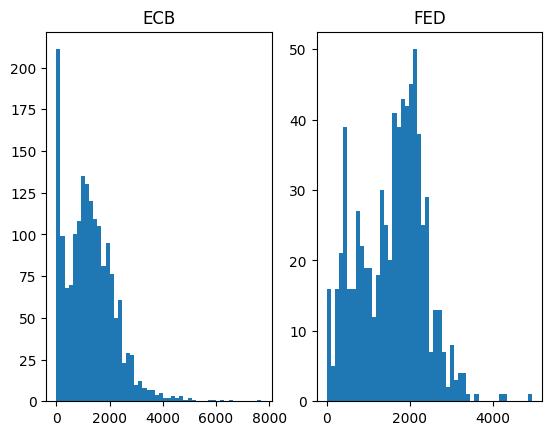

In [14]:
lenght_texts_ecb = [len(str(x).split(" ")) for x in df_ecb.text_process]
lenght_texts_fed = [len(str(x).split(" ")) for x in df_fed.text_process]
fig, ax = plt.subplots(1,2)
ax[0].hist(lenght_texts_ecb, bins=50)
ax[0].set_title("ECB")
ax[1].hist(lenght_texts_fed, bins=50)
ax[1].set_title("FED")
plt.show()

In [ ]:
np.where(np.array(lenght_texts_ecb).astype('int64')<200)

# Text Concatenation

In [55]:
df_series_ecb_process = link_texts_series(df_train_series, df_ecb, "id_series", "id_ecb")
df_series_fed_process = link_texts_series(df_train_series, df_fed, "id_series", "id_fed")

In [58]:
df_train_series = df_train_series.merge(df_series_ecb_process,on='id_series',how='left')
df_train_series = df_train_series.merge(df_series_fed_process,on='id_series',how='left')
df_train_series.head()

,id_series,Index Name,Index - 9,Index - 8,Index - 7,Index - 6,Index - 5,Index - 4,Index - 3,Index - 2,...,id_ecb,id_fed,text_concat_ecb_x,list_speakers_ecb_x,text_concat_fed_x,list_speakers_fed_x,text_concat_ecb_y,list_speakers_ecb_y,text_concat_fed_y,list_speakers_fed_y
0,0,V2X Index,0.001045,0.005841,0.003832,-0.027519,-0.103565,-0.045086,-0.011265,0.005164,...,"[1126, 1471]",[96],Welcome address Welcome remarks by Philip ...,"[Philip R. Lane, Luis de Guindos]",I am delighted to be in Helsinki at this impo...,[Vice Chairman Richard H. Clarida],Welcome address Welcome remarks by Philip ...,"[Philip R. Lane, Luis de Guindos]",I am delighted to be in Helsinki at this impo...,[Vice Chairman Richard H. Clarida]
1,1,MOVE Index,-0.021497,0.007891,-0.013175,-0.008436,0.000000,0.026303,0.000556,0.001455,...,[975],[568],Monetary policy and structural reforms in th...,[Mario Draghi],Watch live I would like to thank the Federa...,[Vice Chairman Stanley Fischer],Monetary policy and structural reforms in th...,[Mario Draghi],Watch live I would like to thank the Federa...,[Vice Chairman Stanley Fischer]
2,2,SPX Index,-0.001872,-0.008154,0.023588,0.004086,0.003493,0.003300,0.000885,-0.011304,...,"[78, 806]","[328, 695]",From challenges to opportunities: rebooting ...,"[Benoît Cœuré, Benoît Cœuré]",I am grateful to the National Association for...,"[Vice Chairman Stanley Fischer, Governor Lael ...",From challenges to opportunities: rebooting ...,"[Benoît Cœuré, Benoît Cœuré]",I am grateful to the National Association for...,"[Vice Chairman Stanley Fischer, Governor Lael ..."
3,3,SPX Index,0.004980,-0.000864,0.001677,0.000000,0.006030,-0.001083,0.000419,0.001492,...,"[560, 1405]",[118],Creating stability in an uncertain world S...,"[Peter Praet, Peter Praet]",Thank you for this invitation to speak here t...,[Governor Jerome H. Powell],Creating stability in an uncertain world S...,"[Peter Praet, Peter Praet]",Thank you for this invitation to speak here t...,[Governor Jerome H. Powell]
4,4,EURUSD Curncy,0.000360,-0.001893,0.005579,-0.003056,-0.001171,-0.001623,-0.002350,-0.006444,...,[404],[261],Money and private currencies: reflections on...,[Yves Mersch],"This year's symposium topic is ""Challenges fo...",[Chairman Jerome H. Powell],Money and private currencies: reflections on...,[Yves Mersch],"This year's symposium topic is ""Challenges fo...",[Chairman Jerome H. Powell]


# Train Test Split

In [60]:
# Train test split 
X=df_train_series.loc[:,df_train_series.columns!="Index + 1"]
y=df_train_series[["Index + 1"]]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)
print(X_train.shape,y_train.shape)

(7156, 22) (7156, 1)


# Embeddings

## Build a vocabulary

## Create the co-occurence Matrix

## Embeddings from the co-occurence Matrix

### SVD

## Sentence Representations

# Save Data